#  $\alpha$-Expansion Moves via Minimal Cuts for Segmentation

#### Authors:
* Ridha Alkhabaz (ridhama2)
* Ali Albazroun (aia)
* Priyam  Mazumdar (priyamm2)

#### Github repository:
You can find our code and more files [here](https://github.com/ridhaalkhabaz/optiz_vision_learning).
#### Outline:

**1- Introduction**

**2- Experiments**

**3- Results**

**4- Conclusions**

#### Introduction:

In [2]:
#Standart scientific python
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch

#Network and image frameworks  
import networkx as nx
import cv2


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Segmentation Problem

Given an image $I \in [0,255]^{w \times h \times d}$ and a set of categorical labels $\mathcal L = \{A,B,C, \dots \}$ we will find a segmentation which will can be described by the fibers of a pixel labelling $f: \mathbb Z_{w\times h} \rightarrow \mathcal L$.

We will use a seperate directory for the example images:

In [3]:
%ls Images

Haus-Koshino.jpg


Let us load one of these images. For example the Koshino House with label colors picked using an image editor

<font color=aacdf5> ■ </font> background $\quad$ <font color=1f3f00> ■ </font> obj1 $\quad$ <font color=1c2b4a> ■ </font> obj2 

Actually for convenience we can assume wlog. that $\mathcal L = \mathbb Z_{|\mathcal L|}$ by simple renaming.


Image of size  (212, 250)  with  3  channels.


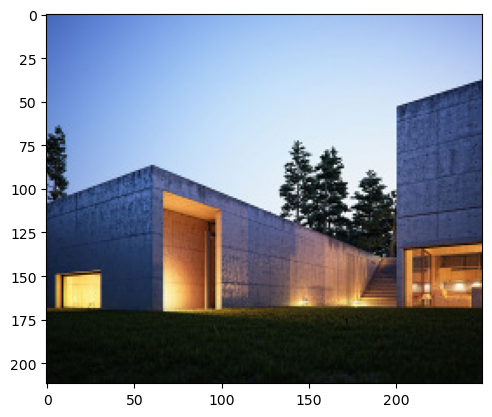

We will try to distinguish  ['background', 'obj1']


In [32]:
#Load an image
img = cv2.imread("Images/Haus-Koshino.jpg", cv2.IMREAD_COLOR)

#Image properties
w,h,d = img.shape
print('Image of size ', (w,h), ' with ', d, ' channels.')

#Display (Matplotlib uses RGB while OpenCV uses BGR)
plt.imshow(img[:,:,::-1]); 
plt.show()

number_of_objects = 1

#Label names and colors
if number_of_objects == 1:
    labels = {
        'background': np.array([245,205,170]), 
        'obj1': np.array([ 74, 43, 28]),
    } 
elif number_of_objects == 2:
    labels = {
        'background': np.array([245,205,170]), 
        'obj1': np.array([ 74, 43, 28]),
        'obj2': np.array([  0, 63, 31]),
    } 
l = len( labels )

#Renaming for convenience
label_names  = [ k for k in labels.keys() ]
label_colors = np.array( [labels[k] for k in labels.keys()] )
labels = [s for s in range(0,l)] #Wlog

print('We will try to distinguish ', label_names)

## Image graph

Represent a given input image as a graph $\mathcal G = (\mathcal V, \mathcal E)$. We will either have a grid graph $\mathcal V = \mathbb Z_{w \times h}$ or a superpixel graph with $|\mathcal V| <\!\!< wh$

In [33]:
#Create grid graph of given size
def grid(w,h):
    G = nx.Graph()
    
    #Grid points are pixels
    N = [(i,j) for i in range(0,w) for j in range(0,h)]
    G.add_nodes_from(N)
    
    #Edges are horizontal and vertical
    E_h = [((i,j), (i+1,j)) for i in range(0,w-1) for j in range(0,h)]
    E_v = [((i,j), (i,j+1)) for i in range(0,w) for j in range(0,h-1)]
    G.add_edges_from(E_h)
    G.add_edges_from(E_v)
    
    return G


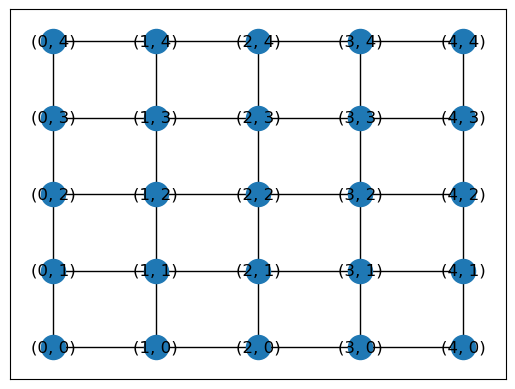

In [34]:
# Example
G = grid(5,5)
pos = dict()
for v in G.nodes():
    pos[v] = v
    
nx.draw_networkx(G,pos)

Superpixels are clustered pixel regions forming a graph smaller than the trivial grid graph of an image. Graph cuts are NP-hard therefore we want make the input graph as small as possible. 

In [36]:
def generate_superpixel_graph(image, size=18):
    w,h,d = image.shape
    
    #Calculate superpixel regions
    spx = cv2.ximgproc.createSuperpixelSLIC(image, region_size=size)
    spx.iterate(); spx.iterate();
    r = spx.getNumberOfSuperpixels()
    regions = spx.getLabels()
    
    #Calculate average colors and positions
    pos = dict() 
    colors = dict()
    for k in range(0,r):
        rows,cols = np.where( regions == k )
        level = np.array( [z for z in zip(rows,cols)] )
        
        pos[k]= np.zeros(2)
        colors[k] = np.zeros( d )
        if len(level) > 0:
            pos[k] = sum(level)/float(len(level))
            for pxl in level:
                colors[k] += image[pxl[0],pxl[1], :]
            colors[k] = np.round( colors[k]/float(len(level)) ).astype(int)
    
    #Setup graph
    G = nx.Graph()
    G.add_nodes_from([n for n in range(0,r)])
    
    #Horizontal
    for i in range(0,w-1):
        for j in range(0,h):
            s = regions[i,j]
            t = regions[i+1,j]
            if s != t:
                G.add_edge(s,t)
    #Vertical
    for i in range(0,w):
        for j in range(0,h-1):
            s = regions[i,j]
            t = regions[i,j+1]
            if s != t:
                G.add_edge(s,t)
    
    return G, regions, colors,pos


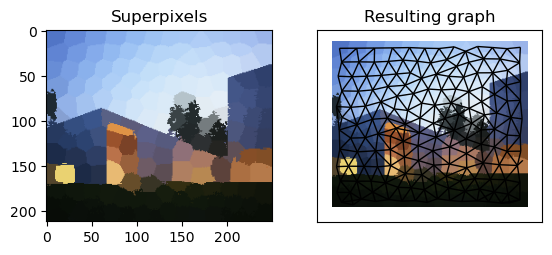

In [37]:
# Example
G,regions,colors,pos = generate_superpixel_graph(img)
spx = np.zeros( (w,h,d) , dtype=int)
for i in range(0,w):
    for j in range(0,h):
        spx[i,j,:] = colors[regions[i,j]]

#Matplotlib and networkx use different coordinates 
nxpos = dict()
for v in G.nodes():
    nxpos[v] = pos[v][::-1]

#Show image regions
plt.subplot(1,2,1)
plt.title('Superpixels')
plt.imshow(spx[:,:,::-1])

#Show graph
plt.subplot(1,2,2)
plt.title('Resulting graph')
plt.imshow(spx[:,:,::-1])
nx.draw_networkx_edges(G,nxpos)
plt.show()

## Unary Costs

Let the unary or data cost be $\theta_v(s) = \| I_v - \chi_s \|^2 $, where $(I_v)_{v\in \mathcal V}$ denote the pixel colors of the graph and $(\chi_s)_{s \in \mathcal L}$ the label colors.

In [38]:
def data_costs(pixels, colors):
    l = len(colors)
    
    #Costs is an array nested in a dictonary of vertices 
    costs = dict()
    for v in pixels.keys():
        costs[v] = np.zeros(l)
        for s in range(0,l):
            sqnorm = np.sum( (pixels[v]-colors[s])**2 )
            costs[v][s] = sqnorm / 255**2
    return costs
    

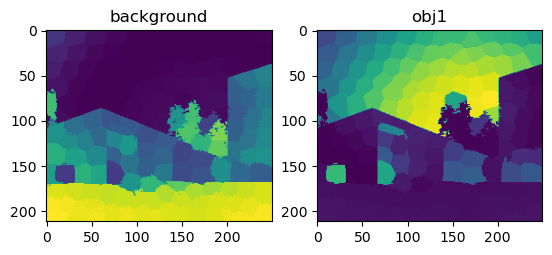

In [39]:
#Example
unary_costs = data_costs( colors, label_colors)

for s in range(0,l):
    plt.subplot(1,l,s+1)
    plt.title( label_names[s] )
    c = np.zeros( (w,h) )
    for i in range(0,w):
        for j in range(0,h):
            c[i,j] = unary_costs[ regions[i,j] ][s]
    plt.imshow(c)
plt.show()

A first guess for an initial labelling is to set $f_v := \text{arg}\min_{s \in \mathcal L} \theta_v(s)$

In [40]:
def first_guess(G, unary_costs):
    f = dict()
    for v in G.nodes():
        f[v] = np.argmin( unary_costs[v] )
    return f

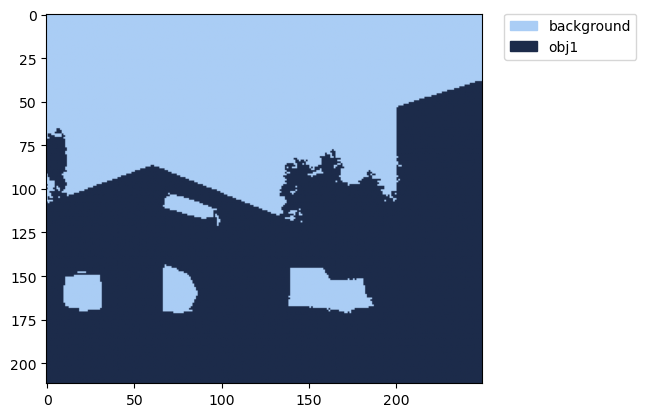

In [41]:
#Example
f = first_guess(G, unary_costs)

#Visualize labelling
labelling = np.zeros( (w,h,d) )
for i in range(0,w):
    for j in range(0,h):
        s = f[regions[i,j]]
        c = label_colors[ s ][::-1]
        labelling[i,j,:] = c / 255.
plt.imshow(labelling)

#Generate legend
patches = []
for s in range(0,l):
    c = label_colors[s][::-1] / 255.
    p = mpatch.Patch( color=c, label=label_names[s]) 
    patches.append(p)
plt.legend( handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

## Pairwise costs

All data costs will be given as dictionaries.

Note that pairwise costs are mostly just given by Potts potential.

In [42]:
def potts(G, labels, weight=1):
    costs = dict()
    for e in G.edges():
        u, v = e
        costs[e] = dict()
        for s in labels:
            for t in labels:
                costs[e][s,t] = weight * int(s != t)
    return costs

In [43]:
#Example
pairwise_costs = potts(G, range(0,l), weight=0.04)

## Optimization Graph

Vertices:
$$ \mathcal V_\alpha := 
     \mathcal V 
\cup \{\alpha, \bar \alpha\}
\cup \bigcup_{uv \in \mathcal E: f_u \neq f_v} \{ p_{uv} \} 
$$

Edges:
$$ \mathcal E_\alpha := 
    \bigcup_{v \in \mathcal V} \{t_v^\alpha, t_v^{\bar \alpha}\}
\cup \bigcup_{uv \in \mathcal E: f_u \neq f_v} \{ (u, p_{uv}), (v, p_{uv}), t_{p_{uv}}^{\bar \alpha} \} 
\cup \{ uv \in \mathcal E \ |\  f_u = f_v \} 
$$

Weights:


edge                | weight
--------------------|--------------------------------------------------------
$ t_v^{\bar \alpha}$|$ \begin{cases} \text{if } f_v=\alpha: & \infty  \\ \text{if } f_v \neq \alpha:  & \theta_v(f_v)\end{cases}$
$ t_v^\alpha $      |$ \theta_v(\alpha) $
$(v,p)$                |$ \theta_{uv}(\alpha, f_v) $
$t_{p_{uv}}^{\bar\alpha}$       |$ \theta_{uv}(f_u, f_v) $
$uv$ with $f_u=f_v$      |  $\theta_{uv}(f_u,\alpha)$

Here $(\theta_v)_{v\in \mathcal V}$ is implemented as node dictonary ```data_costs``` and $(\theta_{uv})_{uv \in \mathcal E}$ as edge dictonary ```edge_costs```.

In [44]:
#Compute alpha-expansion optimization graph
def expansion_graph(G, f, alpha, data_costs, edge_costs):
    G_a = nx.Graph()
    
    #Add nodes
    G_a.add_nodes_from([e for e in G.nodes()])
    G_a.add_node( 'alpha' ) 
    G_a.add_node( 'nonalpha' )
    
    for e in G.edges():
        u,v = e 
        if f[u] == f[v]:
            G_a.add_node( e )
    
    #Add edges with unary costs
    for v in G.nodes():
        G_a.add_edge( v,'alpha', weight=data_costs[v][alpha] )
        if f[v] == alpha:
            G_a.add_edge( v,'nonalpha', weight=float('inf') )
        else:
            G_a.add_edge( v,'nonalpha', weight=data_costs[v][f[v]] )
    
    #Add edges with pairwise costs
    for e in G.edges():
        u,v = e
        if f[u] == f[v]:
            G_a.add_edge( u,v, weight=edge_costs[e][alpha, f[u]] )
        else:
            G_a.add_edge( u, e, weight=edge_costs[e][alpha, f[u]] )
            G_a.add_edge( v, e, weight=edge_costs[e][alpha, f[v]] )
            G_a.add_edge( e, 'nonalpha', weight=edge_costs[e][f[u],f[v]] )
    
    return G_a
            

The networkx library has a builtin graph cut functionality. We will use it.

In [45]:
def alpha_expansion(G, f, alpha, data_costs, edge_costs):
    G_a = expansion_graph(G,f,alpha, data_costs, edge_costs)
    cutvalue, partition = nx.minimum_cut(G_a, 'alpha', 'nonalpha', capacity='weight')
    S,T = partition
    for v in G.nodes():
        if v in T:
            f[v] = alpha
    return f

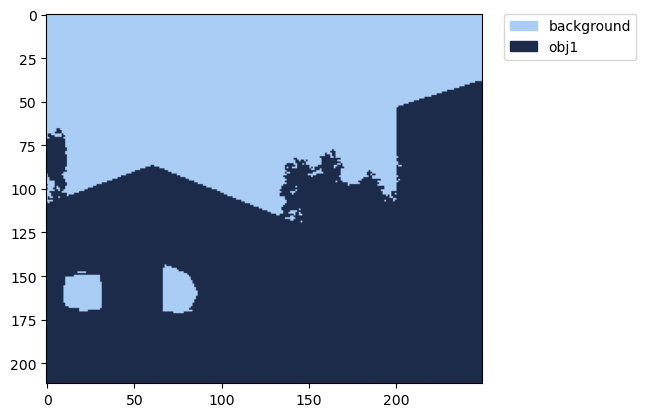

In [46]:
#Example

#Iterate
for alpha in range(0,l):
    f = alpha_expansion(G,f,alpha, unary_costs, pairwise_costs)

#Display labelling
labelling = np.zeros( (w,h,d) )
for i in range(0,w):
    for j in range(0,h):
        s = f[regions[i,j]]
        c = label_colors[ s ][::-1]
        labelling[i,j,:] = c/255.
plt.imshow(labelling)

#Create legend
patches = []
for s in range(0,l):
    c = label_colors[s][::-1]/255.
    p = mpatch.Patch( color=c, label=label_names[s]) 
    patches.append(p)
plt.legend( handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()